<a href="https://colab.research.google.com/github/ajemanuel/melanopsin_model/blob/main/2023_Melanopsin_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This model is an adaptation from that published in [Emanuel & Do, 2015](https://www.sciencedirect.com/science/article/pii/S0896627315001002). Here, we have added high- and low-gain states, mimicking the effects of known feedback events in the melanopsin phototransduction cascade (e.g., arrestin binding).

State diagram of the new model:

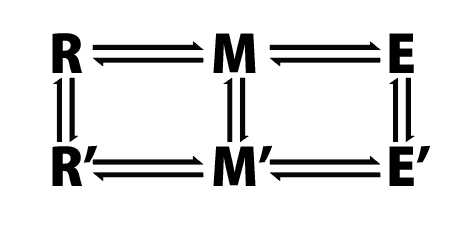



Transitions between $R$, $M$, and $E$ or $R'$, $M'$, and $E'$ occur through photoisomerization. Conversions between the high-gain (e.g., $R$) and low-gain (e.g., $R'$) states are governed by rate constants that vary according to the identity of the state.

For the purpose of this model, we estimate the rate constatn for entry into the low-gain state from the decay of the dim-flash response. The time constant is 6.6 s at 35 °C, therefore the rate is 0.15 s<sup>-1</sup>.

The rate constant for transition from low-gain to high-gain states for inactive forms of melanopsin is 1/22 s<sup>-1</sup>, estimated from FRET analyses of arrestin binding to the beta-2 adrenergic receptor ([Nuber et al., 2016](https://doi.org/10.1038/nature17198)).

We assumed that reverse reactions ($M' → M$, $R → R'$, and $E → E'$) are very slow (1/3600 s<sup>-1</sup>).

Because the $M'$ gain largely sets the size of the persistent response, we estimated it at 3.80% the gain of $M$ based on the ratio of the maximal transient response to the magnitude of persistent activity after a pulse of saturating light (Emanuel et al., 2017).

## Importing Modules, Setting Colors, and Defining Functions

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
import scipy.signal
import os
import seaborn as sns

In [26]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['font.size'] = 6

## colors

MprimeColor = '#D28ABB'
Mcolor = '#663695'
Rcolor = 'k'
RprimeColor = '#808080'
Ecolor = '#EC1E24'
EprimeColor = '#F37F72'

In [27]:
### functions

def nomogram(wlen, lambdamax):
    """
    Calculate the Govardovskii nomogram with beta band for opsins.
    
    Inputs:
    -wlen: ndarray, wlens over which to calculate nomogram
    -lambdamax: float, peak wavelength for nomogram
    
    Output:
    -nomo: ndarray, nomogram
    """
    nomoA = 69.7
    nomoB = 28
    nomoC = -14.9
    nomoD = 0.674
    nomo_a = 0.88
    nomo_b = 0.922
    nomo_c = 1.104
    beta_mb = 189 + 0.315 * lambdamax
    beta_b = -40.5 + 0.195 * lambdamax
    
    
    nomo = 1/((np.exp(nomoA*(nomo_a-(lambdamax/wlen)))) + (np.exp(nomoB*(nomo_b - (lambdamax/wlen)))) + (np.exp(nomoC*(nomo_c - (lambdamax/wlen))) + nomoD)) + 0.26 * np.exp(-((wlen-beta_mb)/beta_b)**2)
    
    return nomo
    

    
    
def eqstate_mono_multipulse(rate, ti, wlen, intensity, lightTimings, konM=0.15, koffR=.0454545, MprimeGain=0.038):
    """
    Calculate R, M, and E approach to equilibrium during monochromatic illumination.
    
    Inputs:
    - rate: float, rate at which to update approach to equilibrium
    - ti: float, time course of experiment
    - wlen: list, wavelengths for each pulse in nm
    - intensity: list, intensity of light for each pulse in ph/micron^2/s
    - lightTimings: list, time periods of illuminations for each pulse
    
    Outputs:
    - xaxis: ndarray, time axis in s
    - R: ndarray, pigment fraction in R state
    - M: ndarray, pigment fraction in M state
    - E: ndarray, pigment fraction in E state
    - Rprime: ndarray, pigment fraction in R' state
    - Mprime: ndarray, pigment fraction in M' state
    - Eprime: ndarray, pigment fraction in E' state
    - currentOut: ndarray, 1.0 * M + MprimeGain * M'
    - currentNoLowGain: ndarray, 1.0 * M + 1.0 * M'
    - lightIntensity: ndarray, intensity of light at each sample

    """
    ## check inputs for validity
    assert len(lightTimings) / len(intensity) == 2, 'Numbers of pulses don\'t match between intensity & lightTimings'
    assert len(lightTimings) /len(intensity) == 2, 'Numbers of pulses don\'t match between wlen & lightTimings'
    
    
    #initial state (all pigment in R state)
    R = np.zeros(int(ti/rate))
    M = np.zeros(int(ti/rate))
    E = np.zeros(int(ti/rate))
    Rprime = np.zeros(int(ti/rate))
    Mprime = np.zeros(int(ti/rate))
    Eprime = np.zeros(int(ti/rate))
    
    R[0] = 1
    M[0] = 0
    E[0] = 0
    Rprime[0] = 0
    Mprime[0] = 0
    Eprime[0] = 0
    
    lightIntensity = np.zeros(len(R))
    lightWavelength = np.zeros(len(R))
    lightPulseID = np.ones(len(R),dtype=np.int32)*-1
    for i in range(0,len(lightTimings),2):
        lightIntensity[int(lightTimings[i]/rate):int(lightTimings[i+1]/rate)] = intensity[int(i/2)]
        lightWavelength[int(lightTimings[i]/rate):int(lightTimings[i+1]/rate)] = wlen[int(i/2)]
        lightPulseID[int(lightTimings[i]/rate):int(lightTimings[i+1]/rate)] = int(i/2)
    # quantum efficiencies
    Rphi = 0.52
    Mphi = 0.22
    Ephi = 0.4
    
    # transition probabilities
    propME = 0.5
    propMR = 1 - propME
    
    # absorption coefficients in units of cm^3/(mol*cm)
    Reps = 33000 * 1000
    Meps = 52600 * 1000
    Eeps = 42000 * 1000
    
    # nomograms
    nomoR = [nomogram(n, 467) for n in wlen]
    nomoM = [nomogram(n, 476) for n in wlen]
    nomoE = [nomogram(n, 446) for n in wlen]
    
    # convert intensity to moles per centimeter squared per time slice per nm
    intensity_conv = [(n/6.022e23)*1e8 for n in intensity] # mol per cm^2 per s
    intensity_conv = [n*rate for n in intensity_conv] # now mol per cm^2 per time slice
    
    # absorptions
    crsum = [np.sum(R_[0] * R_[1] * Reps) for R_ in zip(nomoR,intensity_conv)]
    cmsum = [np.sum(M_[0] * M_[1] * Meps) for M_ in zip(nomoM,intensity_conv)]
    cesum = [np.sum(E_[0] * E_[1] * Eeps) for E_ in zip(nomoE,intensity_conv)]
    
    # here, rate constants are unitless: s^{-1} * updateRate (first-order reaction)
    konR = 1/3600 * rate
    koffR = koffR * rate
    konM = konM * rate
    koffM = 1/3600 * rate
    konE = 1/3600 * rate
    koffE = koffR
    
    for i in range(int(ti/rate)-1):
        ## Two stages -- first consider photoconversions
        
        if lightPulseID[i] != -1:
            R[i+1] = R[i] - np.log(10)*Rphi*crsum[lightPulseID[i]]*R[i] + np.log(10) * Mphi * propMR * cmsum[lightPulseID[i]] * M[i]
            Rprime[i+1] = Rprime[i] - np.log(10)*Rphi*crsum[lightPulseID[i]]*Rprime[i] + np.log(10) * Mphi * propMR * cmsum[lightPulseID[i]] * Mprime[i]
            M[i+1] = M[i] - np.log(10)*Mphi*cmsum[lightPulseID[i]]*M[i] + np.log(10) * Rphi * crsum[lightPulseID[i]] * R[i] + np.log(10) * Ephi * cesum[lightPulseID[i]] * E[i]
            Mprime[i+1] = Mprime[i] - np.log(10)*Mphi*cmsum[lightPulseID[i]]*Mprime[i] + np.log(10) * Rphi * crsum[lightPulseID[i]] * Rprime[i] + np.log(10) * Ephi * cesum[lightPulseID[i]] * Eprime[i]
            E[i+1] = E[i] - np.log(10)*Ephi*cesum[lightPulseID[i]]*E[i] + np.log(10) * Mphi * propME * cmsum[lightPulseID[i]] * M[i]
            Eprime[i+1] = Eprime[i] - np.log(10)*Ephi*cesum[lightPulseID[i]]*Eprime[i] + np.log(10) * Mphi*propME*cmsum[lightPulseID[i]]*Mprime[i]
        else:
            R[i+1] = R[i]
            Rprime[i+1] = Rprime[i]
            M[i+1] = M[i]
            Mprime[i+1] = Mprime[i]
            E[i+1] = E[i]
            Eprime[i+1] = Eprime[i]
            
        
        ## Second, consider light-independent gain-state conversions
        R[i+1] = R[i+1] + Rprime[i+1] * koffR - R[i+1] * konR
        Rprime[i+1] = Rprime[i+1] + R[i+1] * konR - Rprime[i+1] * koffR
        
        M[i+1] = M[i+1] + Mprime[i+1] * koffM - M[i+1] * konM
        Mprime[i+1] = Mprime[i+1] + M[i+1] * konM - Mprime[i+1] * koffM
        
        E[i+1] = E[i+1] + Eprime[i+1] * koffE - E[i+1] * konE
        Eprime[i+1] = Eprime[i+1] + E[i+1] * konE - Eprime[i+1] * koffE
        
    currentOut = M * 1.0 + Mprime * MprimeGain   #/((M * 1.0 + Mprime * MprimeGain) + 0.5) * (3/2) #M*1.0 + Mprime*0.05# 
    currentNoLowGain = M * 1.0 + Mprime * 1.0    #/((M * 1.0 + Mprime * 1.0) + 0.5) * (3/2) ## setting equal M and Mprime gain
    xaxis = np.arange(0,ti,rate)
    return xaxis, R, M, E, Rprime, Mprime, Eprime, currentOut, currentNoLowGain, lightIntensity

## Model Output in Figure 4B

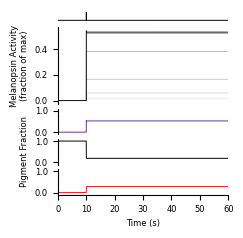

In [28]:
f, ax = plt.subplots(5,1,gridspec_kw={'height_ratios':[0.5,3,1,1, 1]},figsize=[2.2,2.4])

intensities = [10**7,10**7.5,10**8,10**8.5,10**9,10**9.5,10**10] ## in ph per micron squared per s
for i, n in enumerate(intensities):
    inten = [n]
    wlen = np.ones(len(inten))*480
    timings = [10,10.1]
    
    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.0005, 60, wlen, inten, timings)
    if i == len(intensities)-1:
      ax[1].plot(xaxis,currentNoLowGain,lw=0.7,color=str((len(intensities)-i)/len(intensities)-0.05))
    else:
      ax[1].plot(xaxis,currentNoLowGain,lw=0.3,color=str((len(intensities)-i)/len(intensities)-0.05))

ax[0].step(xaxis,lightIntensity/np.max(lightIntensity),lw=0.7,color='k')
ax[2].plot(xaxis,M+Mprime,color=Mcolor,label='M',lw=0.7)
ax[3].plot(xaxis,R+Rprime,color=Rcolor,label='R',lw=0.7)
ax[4].plot(xaxis,E+Eprime,color=Ecolor,label='E',lw=0.7)

ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[-1].set_xlabel('Time (s)')

for a in range(len(ax)):
  if a < 4:
    ax[a].set_xticks([])
  ax[a].spines['top'].set_visible(False)
  ax[a].spines['right'].set_visible(False)
  ax[a].spines['bottom'].set_visible(False)
  ax[a].set_xlim([0,60])
  if a > 1:
    ax[a].set_ylim([-0.1,1.1])
    ax[a].set_yticks([0,1])
    ax[a].set_yticklabels(['0.0','1.0'])
ax[-1].spines['bottom'].set_visible(True)
ax[3].set_ylabel('Pigment Fraction')


ax[0].set_ylim([-0.3,1.3])

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.14)

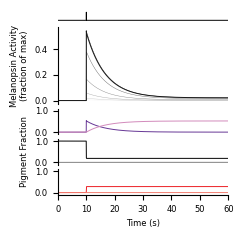

In [29]:
f, ax = plt.subplots(5,1,gridspec_kw={'height_ratios':[0.5,3,1,1, 1]},figsize=[2.2,2.4])

currMax = []
intensities = [10**7,10**7.5,10**8,10**8.5,10**9,10**9.5,10**10] ## in ph per micron squared per s
for i, n in enumerate(intensities):
    inten = [n]
    wlen = np.ones(len(inten))*480


    timings = [10,10.1]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.001, 60, wlen, inten, timings)
    currMax .append(max(current))
    if i == len(intensities)-1:
      ax[1].plot(xaxis,current,lw=0.7,color=str((len(intensities)-i)/len(intensities)-0.05))
    else:
      ax[1].plot(xaxis,current,lw=0.3,color=str((len(intensities)-i)/len(intensities)-0.05))


ax[0].step(xaxis,lightIntensity/np.max(lightIntensity),lw=0.7,color='k')
ax[2].plot(xaxis,M,color=Mcolor,label='M',lw=0.7)
ax[2].plot(xaxis,Mprime,color=MprimeColor,label='M\'',lw=0.7)
ax[3].plot(xaxis,R,color=Rcolor,label='R',lw=0.7)
ax[3].plot(xaxis,Rprime,color=RprimeColor,label='R\'',lw=0.7)
ax[4].plot(xaxis,E,color=Ecolor,label='E',lw=0.7)
ax[4].plot(xaxis,Eprime,color=EprimeColor,label='E\'',lw=0.7)

ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[-1].set_xlabel('Time (s)')
ax[0].set_ylim([5,12])
ax[0].set_yticks([6,8,10])
for a in range(len(ax)):
  if a < 4:
    ax[a].set_xticks([])
  ax[a].spines['top'].set_visible(False)
  ax[a].spines['right'].set_visible(False)
  ax[a].spines['bottom'].set_visible(False)
  ax[a].set_xlim([0,60])
  if a > 1:
    ax[a].set_ylim([-0.1,1.1])
    ax[a].set_yticks([0,1])
    ax[a].set_yticklabels(['0.0','1.0'])
ax[-1].spines['bottom'].set_visible(True)
ax[3].set_ylabel('Pigment Fraction')
ax[0].set_ylim([-0.3,1.3])
ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.14)

## Model Output in Figure 4C

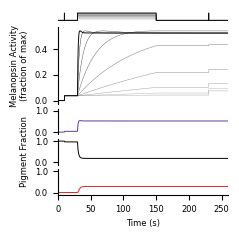

In [30]:
f, ax = plt.subplots(5,1,gridspec_kw={'height_ratios':[0.5,3,1,1, 1]},figsize=[2.2,2.4])

intensities = [10**3,10**3.5,10**4,10**4.5,10**5,10**5.5,10**6,10**6.5,10**7,10**7.5,10**8]
for i, n in enumerate(intensities):
    inten = [10**7.5,n,10**7.5]
    wlen = np.ones(len(inten))*480

    timings = [10,10.2,30,150,230,230.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 260, wlen, inten, timings)
    if i == len(intensities)-1:
      ax[0].step(xaxis,np.bool8(lightIntensity)*i/len(intensities),color=str((len(intensities)-i)/len(intensities)-0.05),lw=0.7)
      ax[1].plot(xaxis,currentNoLowGain,lw=0.7,color=str((len(intensities)-i)/len(intensities)-0.05))
    else:
      ax[0].step(xaxis,np.bool8(lightIntensity)*i/len(intensities),color=str((len(intensities)-i)/len(intensities)-0.05),lw=0.3)
      ax[1].plot(xaxis,currentNoLowGain,lw=0.3,color=str((len(intensities)-i)/len(intensities)-0.05))
ax[2].plot(xaxis,M+Mprime,color=Mcolor,label='M',lw=0.7)
ax[3].plot(xaxis,R+Rprime,color=Rcolor,label='R',lw=0.7)
ax[4].plot(xaxis,E+Eprime,color=Ecolor,label='E',lw=0.7)

ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[-1].set_xlabel('Time (s)')
ax[0].set_ylim([-0.3,1.3])

for a in range(len(ax)):
  if a < 4:
    ax[a].set_xticks([])
  ax[a].spines['top'].set_visible(False)
  ax[a].spines['right'].set_visible(False)
  ax[a].spines['bottom'].set_visible(False)
  ax[a].set_xlim([0,260])
  if a > 1:
    ax[a].set_ylim([-0.1,1.1])
    ax[a].set_yticks([0,1])
    ax[a].set_yticklabels(['0.0','1.0'])
ax[-1].spines['bottom'].set_visible(True)
ax[3].set_ylabel('Pigment Fraction')

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.14)

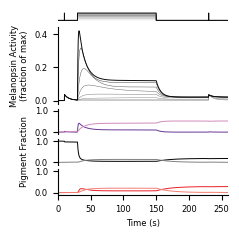

In [31]:
f, ax = plt.subplots(5,1,gridspec_kw={'height_ratios':[0.5,3,1,1, 1]},figsize=[2.2,2.4])

intensities = [10**3,10**3.5,10**4,10**4.5,10**5,10**5.5,10**6,10**6.5,10**7,10**7.5,10**8]

steadyStateResponse = []
persResponse = []

for i, n in enumerate(intensities):
    inten = [10**7.5,n,10**7.5]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,30,150,230,230.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 260, wlen, inten, timings)
    
    steadyStateResponse.append(current[xaxis==145])
    persResponse.append(current[xaxis==229])
    if i == len(intensities)-1:
      ax[0].step(xaxis,np.bool8(lightIntensity)*i/len(intensities),color=str((len(intensities)-i)/len(intensities)-0.05),lw=0.7)
      ax[1].plot(xaxis,current,lw=0.7,color=str((len(intensities)-i)/len(intensities)-0.05))
    else:
      ax[0].step(xaxis,np.bool8(lightIntensity)*i/len(intensities),color=str((len(intensities)-i)/len(intensities)-0.05),lw=0.3)
      ax[1].plot(xaxis,current,lw=0.3,color=str((len(intensities)-i)/len(intensities)-0.05))


ax[2].plot(xaxis,M,color=Mcolor,label='M',lw=0.7)
ax[2].plot(xaxis,Mprime,color=MprimeColor,label='M\'',lw=0.7)
ax[3].plot(xaxis,R,color=Rcolor,label='R',lw=0.7)
ax[3].plot(xaxis,Rprime,color=RprimeColor,label='R\'',lw=0.7)
ax[4].plot(xaxis,E,color=Ecolor,label='E',lw=0.7)
ax[4].plot(xaxis,Eprime,color=EprimeColor,label='E\'',lw=0.7)


ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[-1].set_xlabel('Time (s)')
ax[0].set_ylim([-0.3,1.3])
for a in range(len(ax)):
  if a < 4:
    ax[a].set_xticks([])
  ax[a].spines['top'].set_visible(False)
  ax[a].spines['right'].set_visible(False)
  ax[a].spines['bottom'].set_visible(False)
  ax[a].set_xlim([0,260])
  if a > 1:
    ax[a].set_ylim([-0.1,1.1])
    ax[a].set_yticks([0,1])
    ax[a].set_yticklabels(['0.0','1.0'])
ax[-1].spines['bottom'].set_visible(True)
ax[3].set_ylabel('Pigment Fraction')

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

plt.subplots_adjust(hspace=0.14)

## Model Output in Figure 4D

In [32]:
wlen = [440,440,440,440,560,440] ## specifiying wavelength of each pulse
inten = [10**9,10**9,10**9,10**9,10**10,10**9] # specifiying intensity of each pulse
timings = [10, 12, 70,72, 130,132, 190, 192, 210,230,250, 252] # specify timings of each pulse

xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 300, wlen, inten, timings)

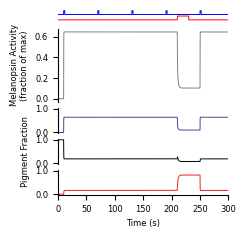

In [33]:
lightColors = {560: 'orange', 440: 'cyan'}
f, ax = plt.subplots(5,1,figsize=[2.2,2.4],gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.copy(lightMonitorAll)
lightMonitor440[(xaxis >= timings[-4]) & (xaxis <= timings[-3])] = False

lightMonitor560 = np.copy(lightMonitorAll)
lightMonitor560[xaxis<=timings[-4]] = False
lightMonitor560[xaxis>=timings[-3]] = False

ax[0].plot(xaxis,lightMonitor440 * 0.5 + 0.7,color='b',lw=0.7)
ax[0].plot(xaxis,lightMonitor560 * 0.5,color='r',lw=0.7)

ax[1].plot(xaxis,currentNoLowGain,color='gray',lw=0.7)
ax[2].plot(xaxis,M+Mprime,color=Mcolor,label='M',lw=0.7)
ax[3].plot(xaxis,R+Rprime,color=Rcolor,label='R',lw=0.7)
ax[4].plot(xaxis,E+Eprime,color=Ecolor,label='E',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,300])
  if axis > 1:
    ax[axis].set_ylim([-0.02,1.02])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')

ax[0].set_ylim([-0.3,1.3])

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

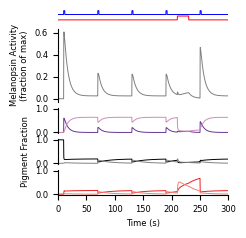

In [34]:
lightColors = {560: 'orange', 440: 'cyan'}
f, ax = plt.subplots(5,1,figsize=[2.2,2.4],gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.copy(lightMonitorAll)
lightMonitor440[(xaxis >= timings[-4]) & (xaxis <= timings[-3])] = False

lightMonitor560 = np.copy(lightMonitorAll)
lightMonitor560[xaxis<=timings[-4]] = False
lightMonitor560[xaxis>=timings[-3]] = False

ax[0].plot(xaxis,lightMonitor440 * 0.5 + 0.7,color='b',lw=0.7)
ax[0].plot(xaxis,lightMonitor560 * 0.5,color='r',lw=0.7)

ax[1].plot(xaxis,current,color='gray',lw=0.7)

ax[2].plot(xaxis,M,color=Mcolor,label='M',lw=0.7)
ax[2].plot(xaxis,Mprime,color=MprimeColor,label='M\'',lw=0.7)
ax[3].plot(xaxis,R,color=Rcolor,label='R',lw=0.7)
ax[3].plot(xaxis,Rprime,color=RprimeColor,label='R\'',lw=0.7)
ax[4].plot(xaxis,E,color=Ecolor,label='E',lw=0.7)
ax[4].plot(xaxis,Eprime,color=EprimeColor,label='E\'',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,300])
  if axis > 1:
    ax[axis].set_ylim([-0.02,1.02])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')
ax[0].set_ylim([-0.3,1.3])

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

## Model Output in Figure S2

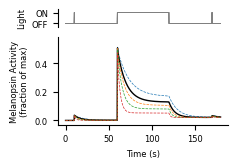

In [35]:
## varying rate constants (kM -> M') - high intensity
f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for konM in [0.1, 0.15, 0.2, 0.3, 0.6]:
    inten = [10**7.5,10**9,10**7.5]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,konM=konM)


    lightColors = {560: 'r', 480: 'cyan'}

    if konM == 0.15:
        ax.plot(xaxis,current,label=konM,linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=konM,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='$K_{M->M\'}  (s^{-1})$',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_ylim([-0.03,0.58])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)


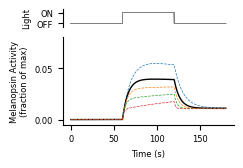

In [36]:
## varying rate constants (kM->M') -- low intensity
f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for konM in [0.1, 0.15, 0.2, 0.3, 0.6]:
    inten = [0,10**6,0]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,konM=konM)


    lightColors = {560: 'r', 480: 'cyan'}

    if konM == 0.15:
        ax.plot(xaxis,current,label=konM,linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=konM,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='$K_{M->M\'}  (s^{-1})$',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_yticks([0,0.05,0.1])
    ax.set_ylim([-0.005,0.08])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

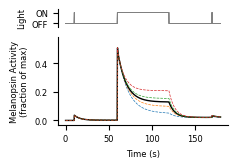

In [37]:
## varying rate constants: KoffR

f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for koffR in [0.01, 0.03, 0.0454545, 0.06, 0.1]:
    inten = [10**7.5,10**9,10**7.5]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,koffR=koffR)


    lightColors = {560: 'r', 480: 'cyan'}

    if koffR == 0.0454545:
        ax.plot(xaxis,current,label='{0:0.3f}'.format(koffR),linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=koffR,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='$K_{R\'->R}  (s^{-1})$',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_ylim([-0.03,0.58])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

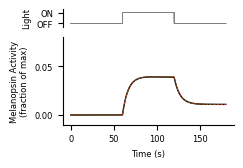

In [38]:
## varying rate constants: KoffR low intensity

f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for koffR in [0.01, 0.03, 0.0454545, 0.06, 0.1]:
    inten = [0,10**6,0]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,koffR=koffR)


    lightColors = {560: 'r', 480: 'cyan'}

    if koffR == 0.0454545:
        ax.plot(xaxis,current,label='{0:0.3f}'.format(koffR),linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=koffR,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='$K_{R\'->R}  (s^{-1})$',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_yticks([0,0.05])
    ax.set_ylim([-0.01,0.08])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

## Model Output in Figure S3

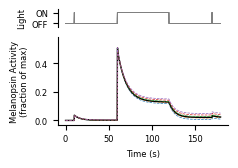

In [39]:
## varying gain of M' state

f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for MprimeGain in [0.01, 0.03, 0.038, 0.05, 0.07, 0.09]:
    inten = [10**7.5,10**9,10**7.5]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,MprimeGain=MprimeGain)


    lightColors = {560: 'r', 480: 'cyan'}

    if MprimeGain == 0.038:
        ax.plot(xaxis,current,label=MprimeGain,linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=MprimeGain,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='M\' Gain (Fraction of M Gain)',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_ylim([-0.03,0.58])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

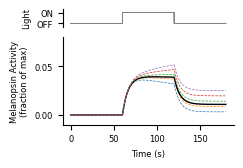

In [40]:
## varying gain of M' state - low intensity

f, [ax2, ax] = plt.subplots(2,1,gridspec_kw={'height_ratios':[1,5]},figsize=[2.2,1.5])

for MprimeGain in [0.01, 0.03, 0.038, 0.05, 0.07, 0.09]:
    inten = [0,10**6,0]
    wlen = np.ones(len(inten))*480


    timings = [10,10.2,60,120,170,170.2]

    xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 180, wlen, inten, timings,MprimeGain=MprimeGain)


    lightColors = {560: 'r', 480: 'cyan'}

    if MprimeGain == 0.038:
        ax.plot(xaxis,current,label=MprimeGain,linewidth=1,color='k')
    else:
        ax.plot(xaxis,current,'--',label=MprimeGain,lw=0.5)

    ax2.plot(xaxis,np.bool8(lightIntensity),lw=0.5,color='gray')
    ax.set_ylabel('Melanopsin Activity\n(fraction of max)')
    #ax.legend(title='M\' Gain (Fraction of M Gain)',ncol=2)
    ax.set_xlabel('Time (s)')
    ax2.set_ylabel('Light')
    ax2.set_ylim([-0.3,1.3])
    ax2.set_yticks([0,1])
    ax2.set_yticklabels(['OFF','ON'])
    ax2.set_xticks([])
    ax.set_yticks([0,0.05])
    ax.set_ylim([-0.01,0.08])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

## Model Output in Figure S4

In [41]:
## approximate figure 3 parameters -- no suppression pulse

wlen = [440, 440, 440, 440] ## specifiying wavelength of each pulse
inten = [10**7,2E9,10**7,2E9] # specifiying intensity of each pulse
timings = [10, 10.1, 30,30.2, 160, 160.1, 180, 180.2] # specify timings of each pulse

xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 250, wlen, inten, timings)

figsize = [2, 2.4]

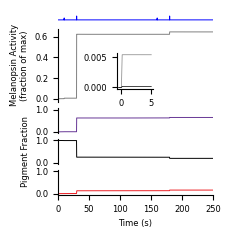

In [42]:
lightColors = {560: 'orange', 440: 'cyan'}
f, ax = plt.subplots(5,1,figsize=figsize,gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.float64(np.copy(lightMonitorAll))
lightMonitor440[(xaxis >= timings[0]) & (xaxis <= timings[1])] = 0.5
lightMonitor440[(xaxis >=timings[-4]) & (xaxis <= timings[-3])] = 0.5

lightMonitor560 = np.zeros(len(lightMonitorAll))

ax[0].plot(xaxis,lightMonitor440 * 0.5,color='b',lw=0.7)

ax[1].plot(xaxis,currentNoLowGain,color='gray',lw=0.7)
ax[2].plot(xaxis,M+Mprime,color=Mcolor,label='M',lw=0.7)
ax[3].plot(xaxis,R+Rprime,color=Rcolor,label='R',lw=0.7)
ax[4].plot(xaxis,E+Eprime,color=Ecolor,label='E',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,250])
  if axis > 1:
    
    #ax[axis].legend(fontsize=6)
    ax[axis].set_ylim([-0.05,1.05])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')

ax[0].set_ylim([-0.3,1.3])

firstFlashNoLowGain = currentNoLowGain[np.where(xaxis==timings[0])[0][0]-100:np.where(xaxis==timings[1])[0][0]+1000].copy()
secondFlashNoLowGain = currentNoLowGain[np.where(xaxis==timings[-4])[0][0]-100:np.where(xaxis==timings[-3])[0][0]+1000].copy()
secondFlashNoLowGain -= secondFlashNoLowGain[0]
flashAxis = np.arange(-100*0.005,(len(firstFlashNoLowGain)-100)*0.005,0.005)

left, bottom, width, height = [0.42, 0.55, 0.18, 0.15]
ax2 = f.add_axes([left, bottom, width, height])

ax2.plot(flashAxis,firstFlashNoLowGain,lw=0.5,color='gray',label='1st')
ax2.plot(flashAxis,secondFlashNoLowGain,lw=0.5,color='k',label='2nd')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.legend()

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

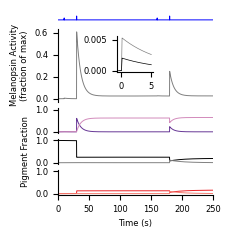

In [43]:
f, ax = plt.subplots(5,1,figsize=figsize,gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.float64(np.copy(lightMonitorAll))
lightMonitor440[(xaxis >= timings[0]) & (xaxis <= timings[1])] = 0.5
lightMonitor440[(xaxis >=timings[-4]) & (xaxis <= timings[-3])] = 0.5

lightMonitor560 = np.zeros(len(lightMonitorAll))
# lightMonitor560 = np.copy(lightMonitorAll)
# lightMonitor560[xaxis<=timings[-4]] = False
# lightMonitor560[xaxis>=timings[-3]] = False

ax[0].plot(xaxis,lightMonitor440 * 0.5,color='b',lw=0.7)
#ax[0].plot(xaxis,lightMonitor560 * 0.5 + 0.7,color='r',lw=0.7)

ax[1].plot(xaxis,current,color='gray',lw=0.7)

ax[2].plot(xaxis,M,color=Mcolor,label='M',lw=0.7)
ax[2].plot(xaxis,Mprime,color=MprimeColor,label='M\'',lw=0.7)
ax[3].plot(xaxis,R,color=Rcolor,label='R',lw=0.7)
ax[3].plot(xaxis,Rprime,color=RprimeColor,label='R\'',lw=0.7)
ax[4].plot(xaxis,E,color=Ecolor,label='E',lw=0.7)
ax[4].plot(xaxis,Eprime,color=EprimeColor,label='E\'',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,250])
  if axis > 1:
    
    #ax[axis].legend(fontsize=6)
    ax[axis].set_ylim([-0.05,1.05])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')
ax[0].set_ylim([-0.3,1.3])

### choose one of the following groups
# ax[0].set_ylabel('Light')
# ax[0].set_yticks([0,1])
# ax[0].set_yticklabels(['OFF','ON'])

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)


firstFlash = current[np.where(xaxis==timings[0])[0][0]-100:np.where(xaxis==timings[1])[0][0]+1000].copy()
secondFlash = current[np.where(xaxis==timings[-4])[0][0]-100:np.where(xaxis==timings[-3])[0][0]+1000].copy()
secondFlash -= secondFlash[0]
flashAxis = np.arange(-100*0.005,(len(firstFlash)-100)*0.005,0.005)

left, bottom, width, height = [0.42, 0.62, 0.18, 0.15]
ax2 = f.add_axes([left, bottom, width, height])

ax2.plot(flashAxis,firstFlash,lw=0.5,color='gray',label='1st')
ax2.plot(flashAxis,secondFlash,lw=0.5,color='k',label='2nd')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.legend()

Text(0.5, 0, 'Time (s)')

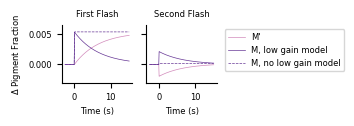

In [44]:
Mprime_firstFlash = Mprime[np.where(xaxis==timings[0])[0][0]-500:np.where(xaxis==timings[1])[0][0]+3000].copy()
M_firstFlash = M[np.where(xaxis==timings[0])[0][0]-500:np.where(xaxis==timings[1])[0][0]+3000].copy()

Mprime_secondFlash = Mprime[np.where(xaxis==timings[-4])[0][0]-500:np.where(xaxis==timings[-3])[0][0]+3000].copy()
M_secondFlash = M[np.where(xaxis==timings[-4])[0][0]-500:np.where(xaxis==timings[-3])[0][0]+3000].copy()
Mcombined_secondFlash = Mprime_secondFlash + M_secondFlash

Mprime_secondFlash -= Mprime_secondFlash[0]
M_secondFlash -= M_secondFlash[0]
Mcombined_secondFlash -= Mcombined_secondFlash[0]

flashAxis = np.arange(-500*0.005,(len(Mprime_firstFlash)-500)*0.005,0.005)

f, ax = plt.subplots(1,2,figsize=[2,0.75])
ax[0].plot(flashAxis,Mprime_firstFlash,color=MprimeColor,label='M\'',lw=0.5)
ax[0].plot(flashAxis,M_firstFlash,color=Mcolor,label='M, low gain model',lw=0.5)
ax[0].plot(flashAxis,Mprime_firstFlash+M_firstFlash,'--',color=Mcolor,label = 'M, no low gain model',lw=0.5)

ax[1].plot(flashAxis, Mprime_secondFlash,color=MprimeColor,label='M\'',lw=0.5)
ax[1].plot(flashAxis,M_secondFlash,color=Mcolor,label='M, low gain model',lw=0.5)
ax[1].plot(flashAxis,Mcombined_secondFlash,'--',color=Mcolor,label='M, no low gain model',lw=0.5)

sns.despine()

ax[0].set_title('First Flash',fontsize=6)
ax[1].set_title('Second Flash',fontsize=6)

ax[0].set_ylim([-0.003,0.0065])
ax[1].set_ylim([-0.003,0.0065])

ax[1].set_yticklabels('')

ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax[0].set_ylabel('$\Delta$ Pigment Fraction')

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')

In [45]:
## approximate figure 3 parameters with the suppression pulse

wlen = [440, 440, 560, 440, 440] ## specifiying wavelength of each pulse
inten = [10**7,2E9,2E9,10**7,2E9] # specifiying intensity of each pulse
timings = [10, 10.1, 30,30.2, 40,70, 160, 160.1, 180, 180.2] # specify timings of each pulse

xaxis, R, M, E, Rprime, Mprime, Eprime, current, currentNoLowGain, lightIntensity = eqstate_mono_multipulse(0.005, 250, wlen, inten, timings)

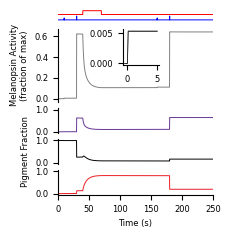

In [46]:
f, ax = plt.subplots(5,1,figsize=figsize,gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.copy(lightMonitorAll)
lightMonitor440[(xaxis >= timings[4]) & (xaxis <= timings[5])] = False
lightMonitor440 = np.float64(np.copy(lightMonitor440))
lightMonitor440[(xaxis >= timings[0]) & (xaxis <= timings[1])] = 0.5
lightMonitor440[(xaxis >=timings[-4]) & (xaxis <= timings[-3])] = 0.5

lightMonitor560 = np.copy(lightMonitorAll)
lightMonitor560[xaxis<=timings[4]] = False
lightMonitor560[xaxis>=timings[5]] = False

ax[0].plot(xaxis,lightMonitor440 * 0.5,color='b',lw=0.7)
ax[0].plot(xaxis,lightMonitor560 * 0.5 + 0.7,color='r',lw=0.7)

ax[1].plot(xaxis,currentNoLowGain,color='gray',lw=0.7)
ax[2].plot(xaxis,M+Mprime,color=Mcolor,label='M',lw=0.7)
ax[3].plot(xaxis,R+Rprime,color=Rcolor,label='R',lw=0.7)
ax[4].plot(xaxis,E+Eprime,color=Ecolor,label='E',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,250])
  if axis > 1:
    
    #ax[axis].legend(fontsize=6)
    ax[axis].set_ylim([-0.05,1.05])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')

ax[0].set_ylim([-0.3,1.3])

firstFlashNoLowGain = currentNoLowGain[np.where(xaxis==timings[0])[0][0]-100:np.where(xaxis==timings[1])[0][0]+1000].copy()
secondFlashNoLowGain = currentNoLowGain[np.where(xaxis==timings[-4])[0][0]-100:np.where(xaxis==timings[-3])[0][0]+1000].copy()
secondFlashNoLowGain -= secondFlashNoLowGain[0]
flashAxis = np.arange(-100*0.005,(len(firstFlashNoLowGain)-100)*0.005,0.005)

left, bottom, width, height = [0.45, 0.65, 0.18, 0.15]
ax2 = f.add_axes([left, bottom, width, height])

ax2.plot(flashAxis,firstFlashNoLowGain,lw=0.5,color='gray',label='1st')
ax2.plot(flashAxis,secondFlashNoLowGain,lw=0.5,color='k',label='2nd')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.legend()

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)

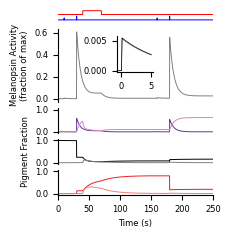

In [47]:
lightColors = {560: 'orange', 440: 'cyan'}
f, ax = plt.subplots(5,1,figsize=figsize,gridspec_kw={'height_ratios':[0.5,3,1,1,1]})

lightMonitorAll = np.bool8(lightIntensity)

lightMonitor440 = np.copy(lightMonitorAll)
lightMonitor440[(xaxis >= timings[4]) & (xaxis <= timings[5])] = False
lightMonitor440 = np.float64(np.copy(lightMonitor440))
lightMonitor440[(xaxis >= timings[0]) & (xaxis <= timings[1])] = 0.5
lightMonitor440[(xaxis >=timings[-4]) & (xaxis <= timings[-3])] = 0.5

lightMonitor560 = np.copy(lightMonitorAll)
lightMonitor560[xaxis<=timings[4]] = False
lightMonitor560[xaxis>=timings[5]] = False

ax[0].plot(xaxis,lightMonitor440 * 0.5,color='b',lw=0.7)
ax[0].plot(xaxis,lightMonitor560 * 0.5 + 0.7,color='r',lw=0.7)

ax[1].plot(xaxis,current,color='gray',lw=0.7)
ax[2].plot(xaxis,M,color=Mcolor,label='M',lw=0.7)
ax[2].plot(xaxis,Mprime,color=MprimeColor,label='M\'',lw=0.7)
ax[3].plot(xaxis,R,color=Rcolor,label='R',lw=0.7)
ax[3].plot(xaxis,Rprime,color=RprimeColor,label='R\'',lw=0.7)
ax[4].plot(xaxis,E,color=Ecolor,label='E',lw=0.7)
ax[4].plot(xaxis,Eprime,color=EprimeColor,label='E\'',lw=0.7)
ax[1].set_ylabel('Melanopsin Activity\n(fraction of max)')
ax[4].set_xlabel('Time (s)')
for axis in range(len(ax)):
  ax[axis].spines['top'].set_visible(False)
  ax[axis].spines['right'].set_visible(False)
  ax[axis].set_xlim([0,250])
  if axis > 1:
    
    #ax[axis].legend(fontsize=6)
    ax[axis].set_ylim([-0.05,1.05])
    ax[axis].set_yticks([0,1])
    ax[axis].set_yticklabels(['0.0','1.0'])
  if axis < 4:
    ax[axis].spines['bottom'].set_visible(False)
    ax[axis].set_xticks([])
ax[3].set_ylabel('Pigment Fraction')
ax[0].set_ylim([-0.3,1.3])

### choose one of the following groups
# ax[0].set_ylabel('Light')
# ax[0].set_yticks([0,1])
# ax[0].set_yticklabels(['OFF','ON'])

ax[0].set_yticks([])
ax[0].spines['left'].set_visible(False)


firstFlash = current[np.where(xaxis==timings[0])[0][0]-100:np.where(xaxis==timings[1])[0][0]+1000].copy()
secondFlash = current[np.where(xaxis==timings[-4])[0][0]-100:np.where(xaxis==timings[-3])[0][0]+1000].copy()
secondFlash -= secondFlash[0]
flashAxis = np.arange(-100*0.005,(len(firstFlash)-100)*0.005,0.005)

left, bottom, width, height = [0.42, 0.62, 0.18, 0.15]
ax2 = f.add_axes([left, bottom, width, height])

ax2.plot(flashAxis,firstFlash,lw=0.5,color='gray',label='1st')
ax2.plot(flashAxis,secondFlash,lw=0.5,color='k',label='2nd')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

Text(0.5, 0, 'Time (s)')

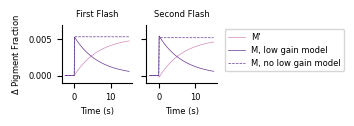

In [48]:
Mprime_firstFlash = Mprime[np.where(xaxis==timings[0])[0][0]-500:np.where(xaxis==timings[1])[0][0]+3000].copy()
M_firstFlash = M[np.where(xaxis==timings[0])[0][0]-500:np.where(xaxis==timings[1])[0][0]+3000].copy()

Mprime_secondFlash = Mprime[np.where(xaxis==timings[-4])[0][0]-500:np.where(xaxis==timings[-3])[0][0]+3000].copy()
M_secondFlash = M[np.where(xaxis==timings[-4])[0][0]-500:np.where(xaxis==timings[-3])[0][0]+3000].copy()
Mcombined_secondFlash = Mprime_secondFlash + M_secondFlash

Mprime_secondFlash -= Mprime_secondFlash[0]
M_secondFlash -= M_secondFlash[0]
Mcombined_secondFlash -= Mcombined_secondFlash[0]

flashAxis = np.arange(-500*0.005,(len(Mprime_firstFlash)-500)*0.005,0.005)

f, ax = plt.subplots(1,2,figsize=[2,0.75])
ax[0].plot(flashAxis,Mprime_firstFlash,color=MprimeColor,label='M\'',lw=0.5)
ax[0].plot(flashAxis,M_firstFlash,color=Mcolor,label='M, low gain model',lw=0.5)
ax[0].plot(flashAxis,Mprime_firstFlash+M_firstFlash,'--',color=Mcolor,label = 'M, no low gain model',lw=0.5)

ax[1].plot(flashAxis, Mprime_secondFlash,color=MprimeColor,label='M\'',lw=0.5)
ax[1].plot(flashAxis,M_secondFlash,color=Mcolor,label='M, low gain model',lw=0.5)
ax[1].plot(flashAxis,Mcombined_secondFlash,'--',color=Mcolor,label='M, no low gain model',lw=0.5)

sns.despine()

ax[0].set_title('First Flash',fontsize=6)
ax[1].set_title('Second Flash',fontsize=6)

ax[0].set_ylim([-0.001,0.007])
ax[1].set_ylim([-0.001,0.007])

ax[1].set_yticklabels('')

ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax[0].set_ylabel('$\Delta$ Pigment Fraction')

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')